In [1]:
using MLDataPattern
using Plots; pyplot()
using ProgressMeter
using JLD
import PyCall
using DrakeVisualizer, GeometryTypes, CoordinateTransformations
DrakeVisualizer.any_open_windows() || DrakeVisualizer.new_window()

true

In [2]:
import Nets
reload("Nets")

INFO: Recompiling stale cache file /home/rdeits/locomotion/explorations/learning-mpc/packages/lib/v0.6/Nets.ji for module Nets.


In [3]:
include("../../pympc.jl")
colmat = PyMPC.colmat

Test Summary:    | Pass  Total
test sensitivity |  267    267


In [4]:
sys = PyMPC.Models.BoxAtlas()

PyMPC.Models.BoxAtlas(PyObject <pympc.models.boxatlas.BoxAtlasPWAModel object at 0x7fc265ccd4d0>)

In [5]:
vis = Visualizer()[:boxatlas]
setgeometry!(vis, sys)

Set{Array{Symbol,1}}()

In [6]:
controller = PyMPC.Models.controller(sys, Q=10*eye(10))

PyObject <pympc.control.MPCHybridController instance at 0x7fc265e21050>

In [7]:
struct Sample
    utraj::Vector{Vector{Float64}}
    xtraj::Vector{Vector{Float64}}
    switching_sequence::Vector{Int}
    u_sensitivity::Matrix{Float64}
end

In [8]:
# num_samples = 100
# num_sim_steps = 20
# data = Vector{Sample}()
# # data = Vector{Tuple{Vector{Float64}, Matrix{Float64}}}()

# @showprogress for i in 1:num_samples
#     while true
#         x0 = PyMPC.Models.generate_x0(sys)
#         settransform!(vis, sys, x0)
#         utraj, xtraj, switching_sequence, J = PyMPC.run_mpc(controller, x0)
#         u = utraj[1]
#         if !isnan(u[1])
#             @assert x0 == xtraj[1]
#             PyMPC.Models.playback(vis, sys, xtraj, 1)
#             push!(data, Sample(utraj, xtraj, collect(switching_sequence), J[1:length(u), :]))
#             for j in 1:num_sim_steps
#                 x = xtraj[2]
#                 utraj = vcat(utraj[2:end], [zeros(utraj[end])])
#                 xnext = try
#                     vec(sys.sys[:pwa_system][:simulate](colmat(xtraj[end]), [colmat(utraj[end-1])])[1][2])
#                 catch e
#                     if isa(e, PyCall.PyError)
#                         zeros(xtraj[end])
#                     else
#                         rethrow(e)
#                     end
#                 end
#                 xtraj = vcat(xtraj[2:end], [xnext])
#                 switching_sequence = (switching_sequence[2:end]..., switching_sequence[end])
#                 utraj, xtraj, switching_sequence, J = PyMPC.run_mpc(controller, x, utraj, xtraj, switching_sequence)
#                 u = utraj[1]
#                 if isnan(u[1])
#                     break
#                 end
#                 @assert x == xtraj[1]
#                 push!(data, Sample(utraj, xtraj, collect(switching_sequence), J[1:length(u), :]))
#                 PyMPC.Models.playback(vis, sys, xtraj, 1)
#             end
#             break
#         end
#     end
#     save("box_atlas_100_traj.jld", "data", data)
# end

# save("box_atlas_100_traj.jld", "data", data)

In [9]:
samples = load("box_atlas_100_traj.jld")["data"];

In [10]:
function features(sample::Sample)
    u = sample.utraj[1]
    x = sample.xtraj[1]
    J = sample.u_sensitivity
    x, hcat(u, J)
end

features (generic function with 1 method)

In [11]:
data = features.(samples)
train_data, test_data = splitobs(shuffleobs(data), 0.5)

train_data_scaled, x_to_u, v_to_y = Nets.rescale(train_data)
u_to_x = inv(x_to_u)
y_to_v = inv(v_to_y)

AffineMap([0.314883 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.253895 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.295239 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.242955 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.53283 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.153005 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.164294 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.15605], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [12]:
data[1][2]

9×11 Array{Float64,2}:
 -0.0        -0.0      -0.0          …  -0.0      -0.0      -0.0        
  0.64587    -0.0       0.515159        -0.0      -0.0       0.923383   
 -0.0        -0.0      -0.0             -0.0      -0.0      -0.0        
  1.01876    -0.0       1.93248e-15     -0.0      -0.0       1.82592e-14
  0.173778   -0.0      -0.0             -0.0      -0.0      -0.0        
  0.0917479  -0.0      -0.0          …  -2.69298  -0.0      -0.0        
 -0.380844   -1.18669  -0.0             -0.0      -2.41876  -0.0        
 -0.380844   -1.18669  -0.0             -0.0      -2.41876  -0.0        
 -0.0        -0.0      -0.0             -0.0      -0.0      -0.0        

In [36]:
widths = [10, 64, 64, 64, 32, 16, 9]
activation = Nets.leaky_relu

function sensitive_loss(λ)
    q = fill(λ, 1, widths[1] + 1)
    q[1] = 1.0 - λ
    (params, x, y) -> sum(abs2, q .* (Nets.predict_sensitivity(Nets.Net(Nets.Params(widths, params), activation), x) .- y))
end

sensitive_loss (generic function with 1 method)

In [37]:
start_params = 0.1 * randn(Nets.Params{Float64}, widths).data
nepoch = 400;

mean((xy->begin  # In[38], line 8:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 1.8029993360344274


Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:02

mean((xy->begin  # In[38], line 16:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 5.248448133193176


Progress: 100%|█████████████████████████████████████████| Time: 0:06:36



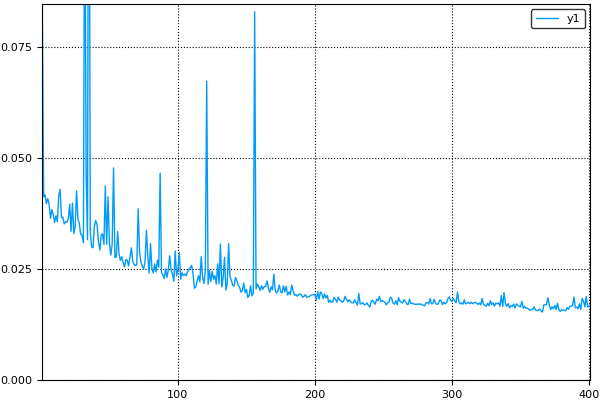

In [38]:
params = copy(start_params)
net = Nets.Net(Nets.Params(widths, params), activation, x_to_u, v_to_y)

train_loss = sensitive_loss(0.5)
validate_loss = train_loss
losses = [mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled)]

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

@showprogress for i in 1:nepoch
#     train_loss = sensitive_loss(0.1)
    Nets.adam!(train_loss, params, train_data_scaled, Nets.AdamOpts(learning_rate=0.01 * 0.99^i, batch_size=10))
    push!(losses, mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled))
end

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

plot(losses, ylim=(0, losses[1]))

In [42]:
netcontroller = x -> clamp.(net(x), -1, 1)

(::#49) (generic function with 1 method)

In [17]:
x0 = PyMPC.Models.generate_x0(sys, controller)
@show x0

x0 = [0.000102126, 0.0640511, -0.0691781, -0.00922239, 0.167509, 0.00866218, -0.157575, 0.104498, 0.0878983, -0.816752]


In [19]:
x0 = [0.17665, 0.149005, 0.109203, 0.112952, 0.0381778, 0.343083, 0.0437361, 0.287838, -0.697056, 0.244723]

10-element Array{Float64,1}:
  0.17665  
  0.149005 
  0.109203 
  0.112952 
  0.0381778
  0.343083 
  0.0437361
  0.287838 
 -0.697056 
  0.244723 

In [63]:
x0 = zeros(10)
x0[end-1] = -0.6
x0[end] = 0.5

0.5

In [65]:
xs = PyMPC.Models.simulate(sys, x0, netcontroller; N_sim=30)
PyMPC.Models.playback(vis, sys, xs)

In [21]:
PyMPC.Models.playback(vis, sys, xs)

LoadError: [91mUndefVarError: xs not defined[39m